In [2]:
from __future__ import absolute_import
from __future__ import print_function
from builtins import range

from autograd.misc.optimizers import adam
from autograd.test_util import check_grads


import matplotlib.pyplot as plt

import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad, hessian_vector_product
from scipy.optimize import minimize
from autograd.scipy.special import logsumexp
import autograd.scipy.stats.multivariate_normal as mvn
from autograd.misc.flatten import flatten_func

from sklearn.cluster import KMeans

In [3]:













def kl_mvn(m0, S0, m1, S1):
   
    # store inv diag covariance of S1 and diff between means
    N = m0.shape[0]
    iS1 = np.linalg.inv(S1)
    diff = m1 - m0

    # kl is made of three terms
    tr_term   = np.trace(iS1 @ S0)
    det_term  = np.log(np.linalg.det(S1)) - np.log(np.linalg.det(S0)) #np.sum(np.log(S1)) - np.sum(np.log(S0))
    quad_term = diff.T @ np.linalg.inv(S1) @ diff #np.sum( (diff*diff) * iS1, axis=1)
    #print("det term {}",format(det_term))
    return .5 * (tr_term + det_term + quad_term - N) 

def kl_inverse_mvn(m1, S1, m0, S0):
    """
    Kullback-Liebler divergence from Gaussian pm,pv to Gaussian qm,qv.
    Also computes KL divergence from a single Gaussian pm,pv to a set
    of Gaussians qm,qv.
    Diagonal covariances are assumed.  Divergence is expressed in nats.

    - accepts stacks of means, but only one S0 and S1

    From wikipedia
    KL( (m0, S0) || (m1, S1))
         = .5 * ( tr(S1^{-1} S0) + log |S1|/|S0| + 
                  (m1 - m0)^T S1^{-1} (m1 - m0) - N )
    """
    # store inv diag covariance of S1 and diff between means
    N = m0.shape[0]
    iS1 = np.linalg.inv(S1)
    diff = m1 - m0

    # kl is made of three terms
    tr_term   = np.trace(iS1 @ S0)
    det_term  = np.log(np.linalg.det(S1)) - np.log(np.linalg.det(S0)) #np.sum(np.log(S1)) - np.sum(np.log(S0))
    quad_term = diff.T @ np.linalg.inv(S1) @ diff #np.sum( (diff*diff) * iS1, axis=1)
    #print(tr_term,det_term,quad_term)
    return .5 * (tr_term + det_term + quad_term - N) 


def kl_div_tot(means,covariances):
    kl_divs = []
    for i in range(0,means.shape[0]):
        #print(i)
        for j in range(i,means.shape[0]):
            #print(i,j)
            kl_divs.append(kl_mvn(means[i],covariances[i],means[j],covariances[j]) )
    #print(kl_divs)        
    return (np.sum(kl_divs))

def kl_div_inverse_tot(means,covariances):
    kl_divs = []
    for i in range(0,means.shape[0]):
        #print(i)
        for j in range(i,means.shape[0]):
            #print(i,j)
            kl_divs.append(kl_inverse_mvn(means[i],covariances[i],means[j],covariances[j]) )
    #print(kl_divs)        
    return (np.sum(kl_divs))


def kl_div_tot_print(means,covariances):
    kl_divs = []
    for i in range(0,means.shape[0]):
        #print(i)
        for j in range(i,means.shape[0]):
            #print(i,j)
            kl_divs.append(kl_mvn(means[i],covariances[i],means[j],covariances[j]) )
    print(kl_divs) 
    print(np.sum(kl_divs))
    #return (np.sum(kl_divs))

def kl_div_inverse_tot_print(means,covariances):
    kl_divs = []
    for i in range(0,means.shape[0]):
        #print(i)
        for j in range(i,means.shape[0]):
            #print(i,j)
            kl_divs.append(kl_inverse_mvn(means[i],covariances[i],means[j],covariances[j]) )
    print(kl_divs) 
    print(np.sum(kl_divs))
    #return (np.sum(kl_divs))
def mvn_logpdf(X, mu, cov_sqrt):
    #print("mvn_logpdf det term is")
    #print(np.linalg.det(2 * np.pi * cov_sqrt.T @ cov_sqrt))
    return - 0.5 * np.log(np.linalg.det(2 * np.pi * cov_sqrt.T @ cov_sqrt)) \
           - 0.5 * np.sum(((X - mu) @ np.linalg.inv(cov_sqrt))**2, axis=1)

def gmm_log_likelihood_cdal_ld(params, data):
    cluster_lls = []
    for log_proportion, mean, cov_sqrt, error in zip(*unpack_fac_params(params)):
        cov = (cov_sqrt@ cov_sqrt.T) + (np.diag(error)@np.diag(error))
        cluster_lls.append(log_proportion + mvn.logpdf(data, mean, cov))
        #cluster_lls.append(log_proportion + mvn_logpdf(data, mean, cov_sqrt))  
    #return cluster_lls
    return np.sum(logsumexp(np.vstack(cluster_lls), axis=0))



# def print_mpkl(means,covariances):
#     kl_divs = []
#     for i in range(0,means.shape[0]):
#         #print(i)
#         for j in range(i,means.shape[0]):
#             #print(i,j)
#             kl_divs.append(kl_inverse_mvn(means[i],covariances[i],means[j],covariances[j]) )
#     print(kl_divs) 
#     print(np.sum(kl_divs))

def print_mpkl(means,covariances):
    kl_divs = []
    for i in range(0,means.shape[0]):
        #print(i)
        for j in range(i,means.shape[0]):
            #print(i,j)
            kl_divs.append(kl_mvn(means[i],covariances[i],means[j],covariances[j]) - kl_inverse_mvn(means[i],covariances[i],means[j],covariances[j])  )
    print(kl_divs)        
    print(np.sum(kl_divs))

    
def print_determinants(covariances):
#     covs = []
    for i in range(0,covariances.shape[0]):
        print(np.linalg.det(covariances[i]))
    

In [4]:
def mvn_logpdf(X, mu, cov_sqrt):
    #print("mvn_logpdf det term is")
    #print(np.linalg.det(2 * np.pi * cov_sqrt.T @ cov_sqrt))
    return - 0.5 * np.log(np.linalg.det(2 * np.pi * cov_sqrt.T @ cov_sqrt)) \
           - 0.5 * np.sum(((X - mu) @ np.linalg.inv(cov_sqrt))**2, axis=1)

def init_gmm_params(num_components, D, scale, rs=npr.RandomState(1)):
    #rs = npr.seed(1)
    return {'log proportions': rs.randn(num_components) * scale,
            'means':           rs.randn(num_components, D) * scale,
            'lower triangles': np.zeros((num_components, D, D)) + np.eye(D)}

def log_normalize(x):
    return x - logsumexp(x)

def unpack_gmm_params(params):
    normalized_log_proportions = log_normalize(params['log proportions'])
    return normalized_log_proportions, params['means'], params['lower triangles']

def gmm_log_likelihood(params, data):
    cluster_lls = []
    for log_proportion, mean, cov_sqrt in zip(*unpack_gmm_params(params)):
        
        cluster_lls.append(log_proportion + mvn_logpdf(data, mean, cov_sqrt))  

    return np.sum(logsumexp(np.vstack(cluster_lls), axis=0))

def alt_gmm_log_likelihood(params, data):
    cluster_lls = []
    for log_proportion, mean, cov_sqrt in zip(*unpack_gmm_params(params)):
        cov = cov_sqrt.T @ cov_sqrt
        cluster_lls.append(log_proportion + mvn.logpdf(data, mean, cov))
    return np.sum(logsumexp(np.vstack(cluster_lls), axis=0))

def plot_ellipse( ax, mean, cov_sqrt, alpha, num_points=100):
    angles = np.linspace(0, 2*np.pi, num_points)
    circle_pts = np.vstack([np.cos(angles), np.sin(angles)]).T * 2.0
    cur_pts = mean + np.dot(circle_pts, cov_sqrt)
    ax.plot(cur_pts[:, 0], cur_pts[:, 1], '-', alpha=alpha)
    plt.plot(cur_pts[:, 0], cur_pts[:, 1], '-', alpha=alpha)
    #plt.show()
    #ax.plot(range(120),range(120))

def plot_gaussian_mixture(params,ax):
    for log_proportion, mean, cov_sqrt in zip(*unpack_gmm_params(params)):
        alpha = np.minimum(1.0, np.exp(log_proportion) * 10)
        plot_ellipse(ax,mean, cov_sqrt, alpha)
        #plot_ellipse(ax, mean, cov_sqrt, alpha)


{'log proportions': array([1.62434536]), 'means': array([[0., 0.]]), 'lower triangles': array([[[-0.61175641, -0.52817175],
        [-1.07296862,  0.86540763]]])}
[[ 1.52550757 -0.60544277]
 [-0.60544277  1.02789576]]


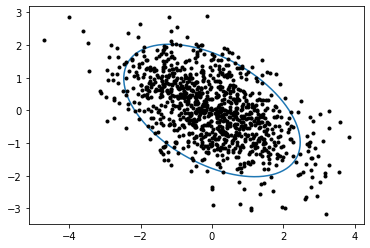

In [20]:
def init_gmm_params(num_components, D, scale, rs=npr.RandomState(1)):
    #rs = npr.seed(1)
    return {'log proportions': rs.randn(num_components) * scale,
            'means':           np.zeros((num_components, D)) * scale,
            'lower triangles': rs.randn(num_components, D, D) }

params_test = init_gmm_params(num_components=1, D=2, scale=1, rs=npr.RandomState(1))
print(params_test)
data_mean = []
data_cov = []
for log_proportion, mean, cov_sqrt in zip(*unpack_gmm_params(params_test)):
    data_cov = cov_sqrt.T@cov_sqrt
    data_mean = mean
    print(data_cov)
data = np.random.multivariate_normal(data_mean, data_cov ,1000)
fig = plt.figure()
ax = fig.add_subplot(111)
for log_proportion, mean, cov_sqrt in zip(*unpack_gmm_params(params_test)):
    num_points = 100
    alpha = np.minimum(1.0, np.exp(log_proportion) * 10)
    angles = np.linspace(0, 2*np.pi, num_points)
    circle_pts = np.vstack([np.cos(angles), np.sin(angles)]).T * 2.0
    cur_pts = mean + np.dot(circle_pts, cov_sqrt)
    ax.plot(cur_pts[:, 0], cur_pts[:, 1], '-', alpha=alpha)
    ax.plot(data[:, 0], data[:, 1], 'k.')
plt.show()

{'log proportions': array([1.76405235]), 'means': array([[0., 0.]]), 'lower triangles': array([[[0.40015721, 0.97873798],
        [2.2408932 , 1.86755799]]])}
[[5.18172812 4.57664706]
 [4.57664706 4.44570089]]
{'log proportions': array([1.62434536]), 'means': array([[0., 0.]]), 'lower triangles': array([[[-0.61175641, -0.52817175],
        [-1.07296862,  0.86540763]]])}
[[ 1.52550757 -0.60544277]
 [-0.60544277  1.02789576]]
{'log proportions': array([-0.41675785]), 'means': array([[0., 0.]]), 'lower triangles': array([[[-0.05626683, -2.1361961 ],
        [ 1.64027081, -1.79343559]]])}
[[ 2.69365428 -2.82152306]
 [-2.82152306  7.77974496]]
{'log proportions': array([1.78862847]), 'means': array([[0., 0.]]), 'lower triangles': array([[[ 0.43650985,  0.09649747],
        [-1.8634927 , -0.2773882 ]]])}
[[3.66314591 0.55903299]
 [0.55903299 0.08625598]]
{'log proportions': array([0.05056171]), 'means': array([[0., 0.]]), 'lower triangles': array([[[ 0.49995133, -0.99590893],
        [ 0.693

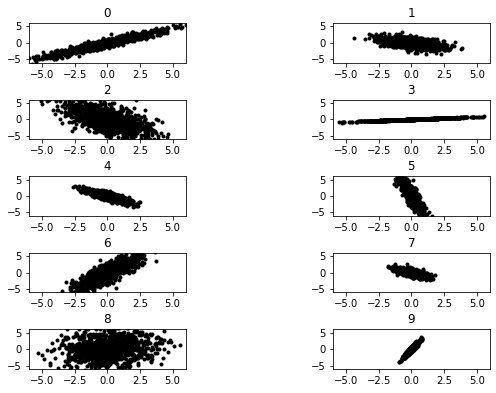

In [32]:
fig = plt.figure(figsize=(8,6))
# ax = fig.add_subplot(111)
for i in range(10):
    params_test = init_gmm_params(num_components=1, D=2, scale=1, rs=npr.RandomState(i))
    print(params_test)
    data_mean = []
    data_cov = []
    for log_proportion, mean, cov_sqrt in zip(*unpack_gmm_params(params_test)):
        data_cov = cov_sqrt.T@cov_sqrt
        data_mean = mean
        print(data_cov)
    data = np.random.multivariate_normal(data_mean, data_cov ,1000)
    ax = fig.add_subplot(5,2,i+1)
    for log_proportion, mean, cov_sqrt in zip(*unpack_gmm_params(params_test)):
        num_points = 100
        alpha = np.minimum(1.0, np.exp(log_proportion) * 10)
        angles = np.linspace(0, 2*np.pi, num_points)
        circle_pts = np.vstack([np.cos(angles), np.sin(angles)]).T * 2.0
        cur_pts = mean + np.dot(circle_pts, cov_sqrt)
        ax.set_xlim(-6,6)
        ax.set_ylim(-6,6)
#         ax.plot(cur_pts[:, 0], cur_pts[:, 1], '-', alpha=alpha)
        ax.plot(data[:, 0], data[:, 1], 'k.')
        ax.set_title(i)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.94, 
                    hspace=0.94)        
plt.show()

{'log proportions': array([1.76405235]), 'means': array([[0., 0.]]), 'lower triangles': array([[[0.40015721, 0.97873798],
        [2.2408932 , 1.86755799]]])}
[[5.18172812 4.57664706]
 [4.57664706 4.44570089]]
{'log proportions': array([1.62434536]), 'means': array([[0., 0.]]), 'lower triangles': array([[[-0.61175641, -0.52817175],
        [-1.07296862,  0.86540763]]])}
[[ 1.52550757 -0.60544277]
 [-0.60544277  1.02789576]]
{'log proportions': array([-0.41675785]), 'means': array([[0., 0.]]), 'lower triangles': array([[[-0.05626683, -2.1361961 ],
        [ 1.64027081, -1.79343559]]])}
[[ 2.69365428 -2.82152306]
 [-2.82152306  7.77974496]]
{'log proportions': array([1.78862847]), 'means': array([[0., 0.]]), 'lower triangles': array([[[ 0.43650985,  0.09649747],
        [-1.8634927 , -0.2773882 ]]])}
[[3.66314591 0.55903299]
 [0.55903299 0.08625598]]
{'log proportions': array([0.05056171]), 'means': array([[0., 0.]]), 'lower triangles': array([[[ 0.49995133, -0.99590893],
        [ 0.693

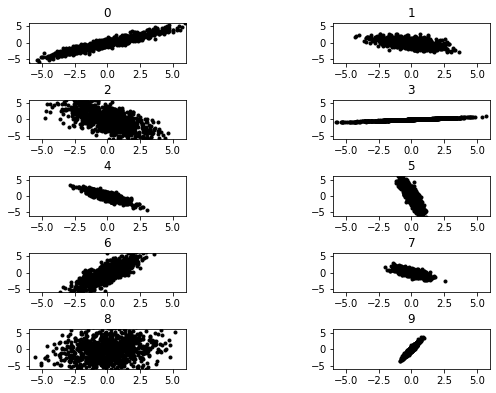

In [34]:
fig = plt.figure(figsize=(8,6))
# ax = fig.add_subplot(111)
for i in range(10):
    params_test = init_gmm_params(num_components=1, D=2, scale=1, rs=npr.RandomState(i))
    print(params_test)
    data_mean = []
    data_cov = []
    for log_proportion, mean, cov_sqrt in zip(*unpack_gmm_params(params_test)):
        data_cov = cov_sqrt.T@cov_sqrt
        data_mean = mean
        print(data_cov)
    data = np.random.multivariate_normal(data_mean, data_cov ,1000)
    ax = fig.add_subplot(5,2,i+1)
    for log_proportion, mean, cov_sqrt in zip(*unpack_gmm_params(params_test)):
        num_points = 100
        alpha = np.minimum(1.0, np.exp(log_proportion) * 10)
        angles = np.linspace(0, 2*np.pi, num_points)
        circle_pts = np.vstack([np.cos(angles), np.sin(angles)]).T * 2.0
        cur_pts = mean + np.dot(circle_pts, cov_sqrt)
        ax.set_xlim(-6,6)
        ax.set_ylim(-6,6)
#         ax.plot(cur_pts[:, 0], cur_pts[:, 1], '-', alpha=alpha)
        ax.plot(data[:, 0], data[:, 1], 'k.')
        ax.set_title(i)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.94, 
                    hspace=0.94)        
plt.savefig('random_matrices.svg')
